读取模型成功！
torch.Size([1, 1, 12498])


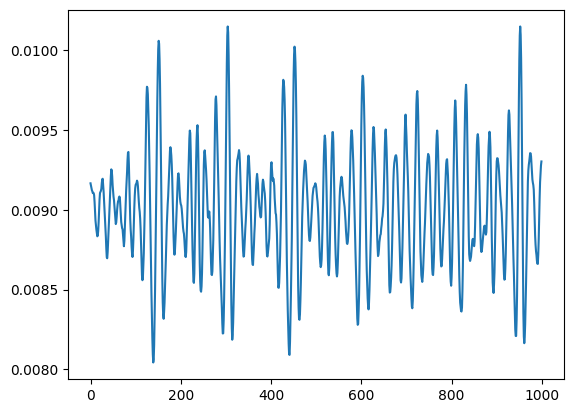

torch.Size([30, 1, 300])


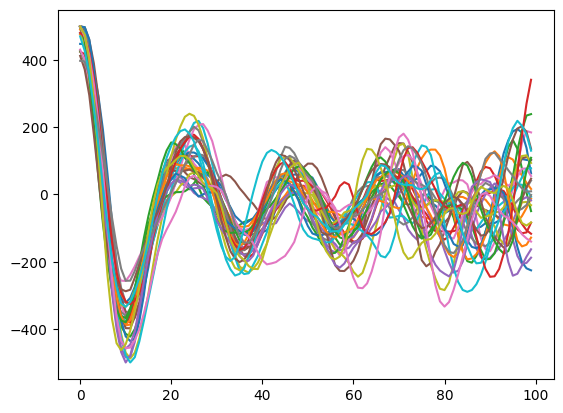

In [1]:
# 滤波后的提取心拍数据

import torch
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from Toolkit import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 读取方式
model2 = torch.load('/root/zqh/Save_Model/model1_2.pth')
model2.eval()
model2 = model2.to(device=device)
print('读取模型成功！')

begin = 5000
end = begin+100000

# data = np.array(pd.read_csv('D:/BCGALL/BCGDataSet/ourdevice/2306测试用/2021年10月bcgecg对照/rrx_bcg_9nf.csv'))[begin:end]
# data = np.array(pd.read_csv('D:/BCGALL/BCGDataSet/ourdevice/0327/zhangjian0327bcg.csv'))[begin:end]
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/pa9-bcg.csv'))[begin:end]
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/ZQH0329.csv'))[begin:end,1:2]
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/ZQH040601bcg.csv'))[begin:end]
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/pa24-bcg.csv'))[begin:end]
data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/kansas_bcg1/pa11.csv'))[begin:end, 9:10] # 9-10 bcg0  11-12 bcg1 13-14 15-16
# save_data_name =       '/root/zqh/NewDataSet/New_data_pa15.pt'

data = data.reshape(1,1,end-begin)
data = bcgFilter(data)
data = data.astype(np.float32)
data = torch.from_numpy(data)
data = avgpool(data=data,stride=8) # Kansas数据预处理
data = data.view(1,1,data.shape[-1])
print(data.shape)

# 去趋势  希望能够修改为可学习性模型层 线性层或卷积层
deckernel_size = 201
avgpool = torch.nn.AvgPool1d(deckernel_size,stride=1)
T = avgpool(data) # 周期趋势
oral_data = data[0][0][deckernel_size//2 : data.shape[-1]-deckernel_size//2]
data = data[0][0][deckernel_size//2 : data.shape[-1]-deckernel_size//2] - T.squeeze(0).squeeze(0)
data = data.view(1,1,data.shape[-1])

ans = data.to(device=device) 

# 滤波
Sc2, _ = model2.returnAns(ans)  # 使用小核输出结果
# Sc2 = model2(ans) # 使用output输出结果

# 绘图
data = data.cpu()
ans = ans.cpu()
Sc2 = Sc2.cpu().detach()

plt.plot(Sc2[0][0][100:1100].detach().numpy())
plt.show()

# 新划分方法
import GateNet
# 通过斜率划分
# index_list = GateNet.getIndexByGrad(Sc2)
# Save_data = torch.zeros(1,1,300)
# for i in range(index_list.__len__()):
#     Save_data = torch.cat([Save_data, Sc2[:,:,index_list[i]:index_list[i]+300]],dim=0)
# Save_data = Save_data[1:,:,:]
# print(Save_data.shape)
# for i in range(index_list.__len__()):
#     plt.plot(Save_data[i][0][0:100].detach().numpy())
# plt.show()

# 通过三峰相似度划分
grad_index1 = GateNet.read_one_peak(data = Sc2[:,:,:int(Sc2.shape[-1]//2)])
grad_index2 = GateNet.read_one_peak(data = Sc2[:,:,int(Sc2.shape[-1]//2):])

heartbeat_length = 300
pre_split_bcg2 = torch.zeros(1,1,heartbeat_length)
# for i in range(len(grad_index) // 30):
for i in range(len(grad_index1)):
    pre_split_bcg2 = torch.cat([pre_split_bcg2, Sc2[:, :, grad_index1[i].index:grad_index1[i].index + heartbeat_length]],
                              dim=0)
for i in range(len(grad_index2)):
    pre_split_bcg2 = torch.cat([pre_split_bcg2, Sc2[:, :, grad_index2[i].index+int(Sc2.shape[-1]//2):grad_index2[i].index + heartbeat_length+int(Sc2.shape[-1]//2)]],
                              dim=0)
pre_split_bcg2 = pre_split_bcg2[1:, :, :]
pre_split_bcg2 = ones_data(pre_split_bcg2)
pre_split_bcg = pre_split_bcg2


muban = torch.mean(pre_split_bcg2[5:10,:,:],dim=0)
# pre_split_bcg = pre_split_bcg[0:150,:,:]

most_list = []
for i in range(pre_split_bcg.shape[0]):
    key = i
    value = C_similarity(pre_split_bcg[i][0][0:100],muban[:,:100])
    most_list.append([key,value])
most_list = sorted(most_list, key=lambda x: (-x[1], x[0]))

most_list = most_list[:30]
ans_list = []
for i in range(most_list.__len__()):
    ans_list.append(most_list[i][0])
pre_split_bcg = pre_split_bcg[ans_list,:,:]

print(pre_split_bcg.shape)
for i in range(pre_split_bcg.shape[0]):
    plt.plot(pre_split_bcg[i][0][0:100].detach().numpy())
plt.show()

# 打乱数据
def shuffle_data(data):
    data1 = data
    index = [i for i in range(data1.shape[0])]
    random.shuffle(index)
    data = data1[index]
    return data
pre_split_bcg = shuffle_data(pre_split_bcg)

# torch.save(pre_split_bcg, save_data_name)
# print('数据保存成功！')